In [1]:
import numpy as np
import pandas as pan
from ast import literal_eval
import matplotlib.pyplot as plot
from sklearn.preprocessing import MinMaxScaler
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
credits=pan.read_csv('/Users/komalipyla/Documents/moviesdataset/credits.csv')
keywords=pan.read_csv('/Users/komalipyla/Documents/moviesdataset/keywords.csv')
metadata = pan.read_csv('/Users/komalipyla/Documents/moviesdataset/movies_metadata.csv').drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
drop([19730, 29503, 35587])
                     


/tmp/ipykernel_50828/1619424268.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pan.read_csv('/Users/komalipyla/Documents/moviesdataset/movies_metadata.csv').drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\


In [3]:
metadata['id'] = metadata['id'].astype('int64')
df = metadata.merge(keywords, on='id').\
    merge(credits, on='id')




In [4]:
metadata[metadata["id"]=="1997-08-20"]

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count


In [5]:
df["tagline"]=df["tagline"].fillna("")
df["runtime"]=df["runtime"].fillna(0)


In [6]:
df=df.dropna(inplace=False)



In [7]:
def segrigate(data, obj='name'):
    data = literal_eval(text)
    
    if len(data) == 1:
        for i in data:
            return i[obj]
    else:
        s = []
        for i in data:
            s.append(i[obj])
        return ', '.join(s)
    
df['genres'] = df['genres'].apply(segrigate)
df['production_companies'] = df['production_companies'].apply(segrigate)
df['production_countries'] = df['production_countries'].apply(segrigate)
df['crew'] = df['crew'].apply(segrigate)
df['spoken_languages'] = df['spoken_languages'].apply(segrigate)
df['keywords'] = df['keywords'].apply(segrigate)

# New columns
df['characters'] = df['cast'].apply(segrigate, obj='character')
df['actors'] = df['cast'].apply(segrigate)

df.drop('cast', axis=1, inplace=True)


In [8]:
df = df[~df['original_title'].duplicated()]


In [9]:
df=df.reset_index(drop=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42363 non-null  object 
 1   budget                42363 non-null  object 
 2   genres                42363 non-null  object 
 3   id                    42363 non-null  int64  
 4   original_language     42363 non-null  object 
 5   original_title        42363 non-null  object 
 6   overview              42363 non-null  object 
 7   popularity            42363 non-null  object 
 8   production_companies  42363 non-null  object 
 9   production_countries  42363 non-null  object 
 10  release_date          42363 non-null  object 
 11  revenue               42363 non-null  float64
 12  runtime               42363 non-null  float64
 13  spoken_languages      42363 non-null  object 
 14  tagline               42363 non-null  object 
 15  vote_average       

In [11]:
df['release_date'] = pan.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

(0.0, 2.0, 0.0, 2.0)

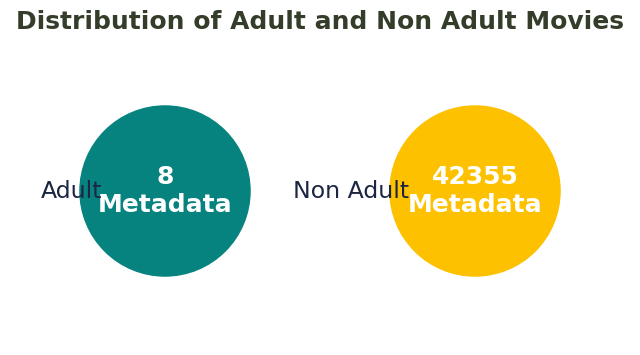

In [12]:
plot.figure(figsize=(8,4))
plot.scatter(x=[0.5, 1.5], y=[1,1], s=15000,color=['#06837f', '#fdc100'])
plot.xlim(0,2)
plot.ylim(0,2)
plot.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plot.text(0.5, 1, '{}\nMetadata'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plot.text(1.5, 1, '{}\nMetadata'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plot.text(0.2, 1.0, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plot.text(1.1, 1.0, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plot.axis("off")

In [13]:
df

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000.0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000.0,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42358,False,0.0,Horror,289923,en,The Burkittsville 7,A film archivist revisits the story of Rustin ...,0.386450,"Neptune Salad Entertainment, Pirie Productions",United States of America,...,0.0,30.0,English,"Do you know what happened 50 years before ""The...",7.0,1.0,"witch, mythology, legend, serial killer, mocku...","Ben Rock, Ben Rock","Branwall, Sarah Didonna, Kyle Brody, Bill Barn...","Monty Bane, Lucy Butler, David Grammer, Bill D..."
42359,False,0.0,Science Fiction,222848,en,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,0.661558,Concorde-New Horizons,United States of America,...,0.0,85.0,English,,3.5,1.0,,"Roger Corman, Mike Elliott, Aaron Osborne, Mik...","Kira (as Cassandra Leigh), Daly, Ruggs, Lewis,...","Lisa Boyle, Kena Land, Zaneta Polard, Don Yana..."
42360,False,0.0,Drama,111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,Sine Olivia,Philippines,...,0.0,360.0,,,9.0,3.0,"artist, play, pinoy","Lav Diaz, Lav Diaz, Dante Perez, Lav Diaz, Lav...","Sister Angela, Homer, Crazy Woman/Virgin, Aman...","Angel Aquino, Perry Dizon, Hazel Orencio, Joel..."
42361,False,0.0,,227506,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,Yermoliev,Russia,...,0.0,87.0,,,0.0,0.0,,"Yakov Protazanov, Joseph N. Ermolieff",", , , 

In [14]:
credits["cast"][0]

"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4t

In [15]:
w1 = df['vote_average']
x1 = df['vote_count']
x2 = df['vote_count'].quantile(0.8)
w2 = df['vote_average'].mean()

df['weighted_average'] = (w1*x1 + w2*x2)/(x1+x2)


In [16]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pan.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

In [17]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [18]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603514,0.841405
Big Hero 6,0.390602,0.827550,0.565381
Baby Driver,0.416507,0.727723,0.540993
Guardians of the Galaxy Vol. 2,0.338511,0.794855,0.521049
Pulp Fiction,0.257449,0.908387,0.517824
Deadpool,0.343132,0.764644,0.511737
Gone Girl,0.282748,0.843403,0.507010
The Dark Knight,0.224968,0.909115,0.498627
Avatar,0.338036,0.732629,0.495873


In [19]:
content_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'release_date','keywords', 'crew', 'characters', 'actors']]

In [20]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

In [21]:
def punctuation(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [22]:
content_df.loc[:,'year'] = pan.DatetimeIndex(content_df['release_date']).year


content_df.drop('release_date', axis=1, inplace=True)

/tmp/ipykernel_50828/413413104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df.loc[:,'year'] = pan.DatetimeIndex(content_df['release_date']).year
/tmp/ipykernel_50828/413413104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df.drop('release_date', axis=1, inplace=True)


In [23]:
content_df.loc[:,'adult'] = content_df['adult'].apply(punctuation)

In [24]:

content_df.loc[:,'genres'] = content_df['genres'].apply(punctuation)
content_df.loc[:,'overview'] = content_df['overview'].apply(punctuation)
content_df.loc[:,'production_companies'] = content_df['production_companies'].apply(separate)
content_df.loc[:,'tagline'] = content_df['tagline'].apply(punctuation)
content_df.loc[:,'keywords'] = content_df['keywords'].apply(separate)
content_df.loc[:,'crew'] = content_df['crew'].apply(separate)
content_df.loc[:,'characters'] = content_df['characters'].apply(separate)
content_df.loc[:,'actors'] = content_df['actors'].apply(separate)

In [25]:
content_df["year"]=content_df["year"].apply(str)


/tmp/ipykernel_50828/1552992654.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df["year"]=content_df["year"].apply(str)


In [26]:
content_df.loc[:,'bag_of_words'] = ''
content_df.loc[:,'bag_of_words'] = content_df[content_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
content_df.set_index('original_title', inplace=True)

content_df = content_df.loc[:,['bag_of_words']]
content_df.head()

/tmp/ipykernel_50828/879228461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df.loc[:,'bag_of_words'] = ''


,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


In [27]:
content_df = weighted_df_sorted[:10000].merge(content_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words="english", min_df=5)

tfidf_matrix = tfidf.fit_transform(content_df.loc[:,'bag_of_words'])
tfidf_matrix.shape

(10000, 28739)

In [28]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape


(10000, 10000)

In [29]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = content_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pan.DataFrame(similarity, columns=['similarity'])
    final_df = pan.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [30]:
predict('Iron Man', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Iron Man,0.329910,1.000000,0.798973
Iron Man 2,0.275277,0.443023,0.392699
Iron Man 3,0.293272,0.289410,0.290569
Mr. Smith Goes to Washington,0.322599,0.275468,0.289607
Avengers: Age of Ultron,0.340100,0.222925,0.258078
Minions,0.841405,0.007816,0.257893
Notorious,0.325436,0.209674,0.244403
Turbo Kid,0.272215,0.207472,0.226895
Guardians of the Galaxy Vol. 2,0.521049,0.097082,0.224272
